In [6]:
! pip install pymc3 --user

In [9]:
! pip install twitter --

In [7]:
import scipy.stats as stats
import pymc3 as pm
import numpy as np


# Coin flip - Bayes-theorem and Bernoulli probability 

This example demonstrates how to apply the Bayes-theorem to a Bernoulli-case (heads/tails) as an educative example.

Suppose one flips a coin. There are only two possible outcomes: heads or tails. In general we do not know if the coin is truly fair (probability, $p$ of heads or tails is 0.5 each) or not fair ($0 < p < 1$ but different from 0.5). This situation can be described by the Bernoulli probability distribution, which is a discrete probability distribution. Its probability mass function (PMF) for the possible outcomes, $k$, is 

$$ \boxed{ f(k;p) = p^{k}(1-p)^{1-k} }$$

In [8]:
# Generate random coin-flip data with Bernoulli
p = 0.25 # ground truth # probqbility of a head/tail #fix parameter p, will give possible outcome 
data = stats.bernoulli.rvs(p, size=50)
print(data)
# We can assign H = 1, T = 0

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 0]


## Bayes-theorem

Now suppose after flipping the coin a few times the set of outcomes is as follows: [H, H, T, H, T] . Is it a fair coin? We can use the Bayes-theorem to try to answer this question. The Bayes-theorem is as follows:

$$ \boxed{ P(A|D) = \frac{P(D|A)P(A)}{P(D)} }$$ 

Here $A$ is a model parameter, $D$ is the set of observed data. The interpretation of this equation is as follows: the probability of the value of the model parameter $A$, given the data $D$ (that is $P(A|D)$), can be calculated from the probability (or likelihood) of the data $D$, given a parameter value $A$ (that is $P(D|A)$), times a _prior_ probability of the parameter value, $P(A)$, and devided by a normalization factor, $P(D)$. The left-hand side is traditionally called the _posterior_ probability (i.e. after seeing the data), while the terms on right-hand side are called the _likelihood_ function and the _prior_ probability.

As the normalization value, $P(D)$, does not depend on the parameter value, we can recast the equation as 

$$ \boxed{ P(A|D) \propto P(D|A)P(A)}$$ 

The objective is to calculate the left-hand side by evaluating the known quantities on the right-hand side.
We can solve this analytically to calculate the left-hand side in this simple case, but this example serves to show you the numerical way of evaluating this using the very easy PyMC3 python package.

## Evaluate the right-hand side

To evaluate the right-hand side we should write out the terms for our coin-flip case. The likelihood of the data is simply given by the Bernoulli PMF above. $D$ will denote the set of outcomes, and $A$ denotes the parameter $p$ so our equation is:

$$ \boxed{ P(p|D) \propto P(D|p)P(p) }$$

For a dataset of N independent Bernoulli-trials with k Heads and (N-k) tails the overall likelihood is: 

$$ \boxed{ P(D|p) = p^{k}(1-p)^{N-k} }$$

The prior probability is somewhat arbitrary, and initially, when the amount of observation or data is still few, the prior is going to dominate the result. But by collecting more and more data (as we will see) the prior will not influence the result anymore. One typical choice is a _flat_ prior, that is we say that we allow any value for $p$. 


$$ \boxed{ P(p) = \begin{cases}
    1 & 0 \le p \le 1 \\
    0 & \mathrm{otherwise.}
    \end{cases} }$$
    
Finally, we code this in PyMC3. See the code below.


In [3]:
# Likelihood model is Bernoulli with parameter p
# Model the prior on p with Uniform distribution

with pm.Model() as coin_flipping:
    # Prior
    p = pm.Uniform("p", lower=0, upper = 1)
    # Likelihood
    y = pm.Bernoulli("y", p=p, observed=data)
    # instantiate sampler (optional) # searching for random parameters 
    step = pm.Metropolis() 
    # Draw posterior samples
    trace = pm.sample(10000, tune=2000, step = step, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


Perhaps the only non-trivial parts of the code were the lines:

```
    # instantiate sampler (optional)
    step = pm.Metropolis() 
    # Draw posterior samples
    trace = pm.sample(10000, tune=1000, step = step, return_inferencedata=True)
```

This is the core of the numerical application of the Bayes-theorem. Even though we could write up the right-hand side of the Bayes-theorem, the data values (the $k_i$ values) are fixed to the observed outcomes, it still remains a function of the Bernoulli parameter value, $p$. A common way to explore the parameter space for the $p$ value is to run a Markov Chain Monte Carlo (MCMC), in this particular case with a Metropolis-Hastings algorithm. This algorithm steps through various values of $p$ randomly, and every time evaluates the likelihood of that particular value of $p$, given the data. It is beyond the scope of this example, but PyMC3 makes is simple for you.

Once you got the code running you can visualize the explored parameters values but plotting a histogram (or density) and a trace of the $p$ parameter values as a function of the MCMC steps.

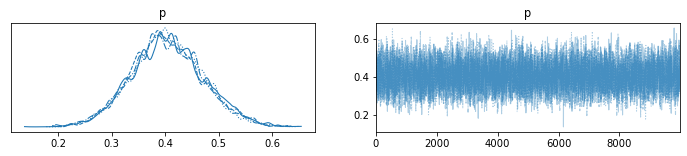

In [4]:
# Plot trace of MCMC
import arviz as az
az.plot_trace(trace, var_names=["p"]);

# left hand side data

We can extract and plot the mean of the posterior distribution as well as the 95% highest density interval. 

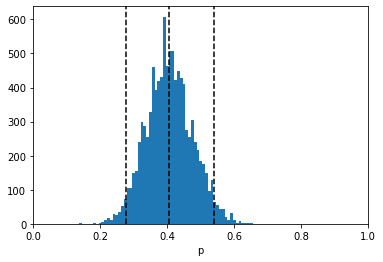

Mean, 2.5 and 97.5 percentiles, p = 0.40 -0.28 +0.54 


In [5]:
import matplotlib.pyplot as plt
#ax = pm.plot_posterior(trace, hdi_prob=0.95)
#ax.set_xlim(0, 1)
#ax.set_xlabel('p')


# Plot the distribution of the sample means as a histogram
fig, ax = plt.subplots(1, 1)
plt.hist(trace["posterior"]["p"][0], bins='auto')
ax.set_xlim(0, 1)
p_mean = np.mean(trace["posterior"]["p"][:])
p_low = np.percentile(trace["posterior"]["p"][:],[2.5,97.5])[0] 
p_high = np.percentile(trace["posterior"]["p"][:],[2.5,97.5])[1]
plt.axvline(p_low, c='k', ls='--')
plt.axvline(p_high, c='k', ls='--');
plt.axvline(p_mean, c='k', ls='--');
ax.set_xlabel("p")

plt.show()

print("Mean, 2.5 and 97.5 percentiles, p = %.2f -%.2f +%.2f " % (p_mean, p_low, p_high))



In [6]:
p_mean = np.mean(trace["posterior"]["p"][:])
p_low = np.percentile(trace["posterior"]["p"][:],[2.5,97.5])[0]
p_high = np.percentile(trace["posterior"]["p"][:],[2.5,97.5])[1]
print("Mean, 2.5 and 97.5 percentiles, p = %.2f -%.2f +%.2f " % (p_mean, p_low, p_high))

Mean, 2.5 and 97.5 percentiles, p = 0.40 -0.28 +0.54 


We can also get a summary of the posterior distribution.

In [7]:
az.summary(trace, hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.404,0.067,0.271,0.534,0.001,0.001,8282.0,8568.0,1.0


In [8]:
#az.mcse(trace, method="quantile", prob=0.95)
az.summary(trace, hdi_prob=0.95, fmt="xarray")

<xarray.Dataset>
Dimensions:  (metric: 9)
Coordinates:
  * metric   (metric) <U9 'mean' 'sd' 'hdi_2.5%' ... 'ess_tail' 'r_hat'
Data variables:
    p        (metric) float64 0.404 0.06694 0.2708 ... 8.282e+03 8.568e+03 1.001

## Posterior sampling of the parameter 

In [9]:
# Generate posterior parameter sample
posterior_predictive = pm.sample_posterior_predictive(
            trace, var_names=["p"], model=coin_flipping, random_seed=0, samples=10, 
        )
print(posterior_predictive)
#posterior_preds = posterior_predictive["p"]
#print(posterior_preds)

C:\Users\Rosalyn\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'p': array([0.45889968, 0.31553612, 0.42185943, 0.42185943, 0.42185943,
       0.42185943, 0.46099228, 0.46099228, 0.46099228, 0.51006847])}


In [10]:
print(trace.posterior)

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 10000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    p        (chain, draw) float64 0.4589 0.3155 0.4219 ... 0.3652 0.3652 0.4514
Attributes:
    created_at:                 2022-09-12T18:47:55.043662
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              44.45352482795715
    tuning_steps:               2000


## Auto-correlation plots

Auto-correlation reveals how much correlation exist in the subsequent values during the stepping through the parameters, with increasing lagging. This is used as a diagnostic. 

C:\Users\Rosalyn\AppData\Local\Temp\ipykernel_17588\152698311.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  pm.autocorrplot(trace, combined=True)


<AxesSubplot:title={'center':'p'}>

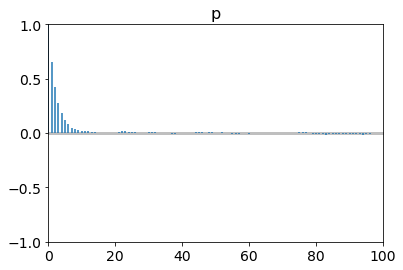

In [11]:
pm.autocorrplot(trace, combined=True)

## Posterior-predictive assessment of fit (Bayesian goodness-of-fit)

Once we obtain the posterior distribution we can sample from it, because we can predict new values. Given a set of N i.i.d. observations $D = {y_1, y_2, ..., y_N}$, a new (vector of) value(s) of $\hat{y}$ can be drawn from the posterior distribution, using the posterior as our new prior:

$$ \boxed{ P(\hat{y}|D) = \int P(\hat{y}|p)P(p|D)dp }$$

Now, we can qualify and quantify the agreement of the data with our best-fit model. We sample the posterior to draw  parameter values, and calculate a test statistics distribution, which we can compare with the test statistic value for the actual observation.

1. Using the posterior, we generate 'fake' data samples (10 data values of coin-flips for each random posterior-sample), and calculate the 'sample mean' for each sample, which we use as a test statistics. Thus, we get a distribution of the 'sample mean' for this 'fake data'. 

1a. Alternatively, we can just sample from the MCMC chain value, it is faster and uses the values actually explored, given the data.

2. We compare the observed sample mean calculated from the real data with the test-statistics distribution from the posterior-predictive samples.

In [12]:
Nrepeat = 1000
Nsample = 10
sample_mean_set = []

# Sample from the MCMC chain
for i in range(Nrepeat):
    # Sample the trace parameter values from the MCMC chain
    fake_data = np.random.choice(trace["posterior"]["p"][0], size=Nsample)

    # Calculate sample mean
    sample_mean_set.append(np.mean(fake_data))


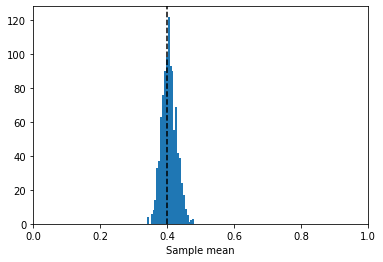

In [13]:
# Plot the distribution of the sample means as a histogram
fig, ax = plt.subplots(1, 1)
plt.hist(sample_mean_set, bins='auto')
ax.set_xlim(0, 1)
#plt.axvline(np.percentile(chain_s,[2.5,97.5])[0], c='k', ls='--')
#plt.axvline(np.percentile(chain_s,[2.5,97.5])[1], c='k', ls='--');
plt.axvline(np.mean(data), c='k', ls='--');
ax.set_xlabel("Sample mean")

plt.show()
